In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# This notebook was created to construct a supplementary table with *accession IDs* for all isolates in our sample and to identify the geographical origin of each isolate for isolates that have this meta-data

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC
from Bio import Phylo

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools
import gzip

import networkx as nx
import scipy
from collections import Counter
from itertools import groupby
from operator import itemgetter

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

####################################################################################################################################################################################

# [1] Load Sample Annotation Files & Sample Metadata Files

####################################################################################################################################################################################

In [3]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

#load SNP annotation file (rows of Genotype Matrix) with gene annotation information
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl')

Columns of Genotype Matrix

In [4]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1


In [5]:
np.shape(isolate_annotation_DF)

(31428, 14)

Rows of Genotype Matrix

In [6]:
SNP_annotation_DF.head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,48,C,[T],Rv0001,47.0,Essential,dnaA
1,64,G,[C],Rv0001,63.0,Essential,dnaA
2,67,G,"[A, T]",Rv0001,66.0,Essential,dnaA
3,69,C,[T],Rv0001,68.0,Essential,dnaA
4,71,C,[T],Rv0001,70.0,Essential,dnaA


In [7]:
np.shape(SNP_annotation_DF)

(782565, 7)

#### Retrieve geographical data for isolates

In [8]:
geographic_isolate_df_A = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/RRDR_mutant_project/GEO data/geo_sampling.txt', sep="\t", header=0).set_index('BioSample')
geographic_isolate_df_B = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/RRDR_mutant_project/GEO data/validation_ids_TableS4.csv', sep=",", header=0).set_index('Isolate ID')

In [9]:
geographic_isolate_df_A.head(n=3)

,isolation_country,collection_year,tag
BioSample,,,
SAMEA787746,Uganda,2005.0,"patric,ncbi"
SAMN08684019,Lebanon,2017.0,"patric,ncbi"
SAMN09566410,South Africa,2011.0,"patric,ncbi"


In [10]:
np.shape(geographic_isolate_df_A)

(64933, 3)

In [11]:
geographic_isolate_df_B.head(n=3)

,Count,Source,Lab,Country
Isolate ID,,,,
1478813216721T177115lib4769nextseqn0035151bp,1,ReseqTB,Borstel,Germany
1478813216721T177215lib4770nextseqn0035151bp,2,ReseqTB,Borstel,Germany
1478813216721T177315lib4771nextseqn0035151bp,3,ReseqTB,Borstel,Germany


In [12]:
np.shape(geographic_isolate_df_B)

(792, 4)

####################################################################################################################################################################################

# [3] Get geographical information for samples

####################################################################################################################################################################################

Concatenate geographic information into one df

In [13]:
isolate_tags = list(geographic_isolate_df_A.index) + list(geographic_isolate_df_B.index)

In [14]:
len(isolate_tags)

65725

In [15]:
len(set(isolate_tags)) #check for no repeats

65725

In [16]:
geographic_isolate_df = pd.DataFrame(index = isolate_tags)
geographic_location_list = list(geographic_isolate_df_A.isolation_country) + list(geographic_isolate_df_B.Country)
geographic_isolate_df.loc[:, 'country'] = geographic_location_list

In [17]:
geographic_isolate_df.head(n=3)

,country
SAMEA787746,Uganda
SAMN08684019,Lebanon
SAMN09566410,South Africa


In [18]:
np.shape(geographic_isolate_df)

(65725, 1)

Drop **nan** values, isolates with no country info

In [19]:
isolates_with_country_filter = geographic_isolate_df.loc[: , 'country'].isnull() == False
geographic_isolate_df = geographic_isolate_df[isolates_with_country_filter]

In [20]:
np.shape(geographic_isolate_df)

(48261, 1)

Append to isolate annotation DF

In [21]:
isolate_country_origin_list = []

for isolate_id in isolate_annotation_DF.isolate_ID:
    
    if isolate_id in geographic_isolate_df.index:
        
        isolate_country_origin_list.append(geographic_isolate_df.loc[isolate_id , 'country'])
        
    else:
        
        isolate_country_origin_list.append('#')
        
isolate_annotation_DF['country'] = isolate_country_origin_list

In [22]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group,country
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B,#
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B,#
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3,#
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B,#
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1,United Kingdom


In [23]:
isolate_annotation_DF[isolate_annotation_DF.country != '#'].tail()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group,country
31422,1,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMEA1485358,1.2.2.1,1,Malawi
31423,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA1530754,4.2.1.2.1.1.i3.1,4B,Malawi
31424,4,2,1,2,1,1,i4,1,NaN,NaN,NaN,SAMEA104708028,4.2.1.2.1.1.i4.1,4B,Brazil
31426,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA1465982,4.2.1.2.1.1.i3.1,4B,Malawi
31427,4,2,1,1,1,1,1,1,i1,NaN,NaN,SAMEA1523377,4.2.1.1.1.1.1.1.i1,4C,South Africa


In [24]:
np.shape(isolate_annotation_DF)

(31428, 15)

In [25]:
np.shape(isolate_annotation_DF[isolate_annotation_DF.country != '#']) #number of isolates WITH country info

(21500, 15)

In [26]:
np.shape(isolate_annotation_DF[isolate_annotation_DF.country == '#']) #number of isolates WITHOUT country info

(9928, 15)

####################################################################################################################################################################################

# [4] Examine geographical distribution

####################################################################################################################################################################################

In [27]:
from collections import Counter

In [28]:
num_isolates_per_country = pd.Series( Counter( isolate_annotation_DF.country ) )
num_isolates_per_country.sort_values(ascending = False, inplace = True)
num_isolates_per_country.head(n=25)

#                 9928
South Africa      3340
United Kingdom    2987
Peru              1593
Vietnam           1391
Malawi            1362
Canada            1352
Russia             995
Ukraine            995
Azerbaijan         667
China              638
Netherlands        523
Bangladesh         518
USA                376
Japan              369
Pakistan           346
Moldova            316
Germany            305
Thailand           288
Denmark            284
Italy              230
India              212
Brazil             190
DR Congo           189
Argentina          169
dtype: int64

In [29]:
num_isolates_per_country['Italy']

230

In [30]:
num_isolates_per_country['Belarus']

37

In [31]:
num_isolates_per_country['Iran']

5

#### Drop samples count that didn't have country data

In [32]:
num_isolates_per_country = num_isolates_per_country[num_isolates_per_country.index != '#']

In [33]:
np.shape(num_isolates_per_country)

(80,)

In [34]:
num_isolates_per_country.head(n=5)

South Africa      3340
United Kingdom    2987
Peru              1593
Vietnam           1391
Malawi            1362
dtype: int64

How many isolates out of **31,428** did we have geographical information for?

In [35]:
float(num_isolates_per_country.sum())

21500.0

In [36]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

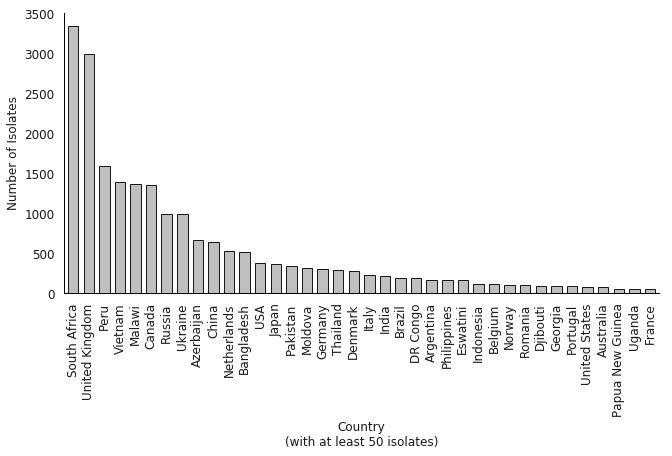

In [45]:
countries_with_many_isolates_series = num_isolates_per_country[num_isolates_per_country >= 50]

# data to plot
n_groups = np.shape(countries_with_many_isolates_series)[0]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.67
opacity = 1.0
edgecolor = 'k'
linewidth = 1.0

rects1 = plt.bar(index, countries_with_many_isolates_series, bar_width,
alpha=opacity,
color='0.75',
label='Countries with >= 50 samples',
linewidth = linewidth,
edgecolor = edgecolor)

plt.xlabel('Country\n(with at least 50 isolates)' , color = 'k' , fontsize = 12)
plt.ylabel('Number of Isolates', color = 'k' , fontsize = 12)
plt.xticks(index, countries_with_many_isolates_series.index, rotation = 90, fontsize = 11)
plt.xlim(min(index)-0.6, max(index)+0.6)
#plt.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(9.5, 6.5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/for publication/PNAS_reviews/sample_breakdown_by_country.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [38]:
np.shape(countries_with_many_isolates_series)

(38,)

In [39]:
countries_with_many_isolates_series

South Africa        3340
United Kingdom      2987
Peru                1593
Vietnam             1391
Malawi              1362
Canada              1352
Russia               995
Ukraine              995
Azerbaijan           667
China                638
Netherlands          523
Bangladesh           518
USA                  376
Japan                369
Pakistan             346
Moldova              316
Germany              305
Thailand             288
Denmark              284
Italy                230
India                212
Brazil               190
DR Congo             189
Argentina            169
Philippines          166
Eswatini             160
Indonesia            122
Belgium              118
Norway               107
Romania               98
Djibouti              90
Georgia               86
Portugal              85
United States         77
Australia             75
Papua New Guinea      57
Uganda                54
France                51
dtype: int64

####################################################################################################################################################################################

# [5] Examine lineage distribution

####################################################################################################################################################################################

In [40]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group,country
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B,#
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B,#
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3,#
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B,#
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1,United Kingdom


In [41]:
num_isolates_per_global_lineage = pd.Series( Counter( isolate_annotation_DF.lineage_1 ) )

In [42]:
num_isolates_per_global_lineage

1     2815
2     8090
3     3398
4    16931
5       98
6       96
dtype: int64

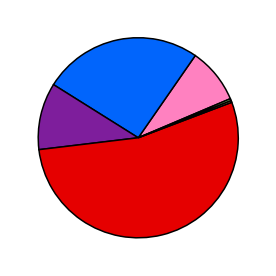

In [46]:
pie_slice_proportions = []
labels = []
colors = []

for lineage_call in num_isolates_per_global_lineage.index:
    
    proportion = float(num_isolates_per_global_lineage[lineage_call]) / float(num_isolates_per_global_lineage.sum())
    pie_slice_proportions.append(proportion)
    labels.append(lineage_call)
    
    if lineage_call[0] == '1':
        colors.append('xkcd:pink')
    if lineage_call[0] == '2':
        colors.append('xkcd:bright blue')
    if lineage_call[0] == '3':
        colors.append('xkcd:purple')
    if lineage_call[0] == '4':
        colors.append('xkcd:red')
    if lineage_call[0] == '5':
        colors.append('xkcd:light brown')
    if lineage_call[0] == '6':
        colors.append('xkcd:light green')
        
# Make square figures and axes
the_grid = GridSpec(1, 1)

fig, ax = plt.subplots()

wedges, texts = ax.pie(pie_slice_proportions, shadow=False , colors = colors , wedgeprops = {'linewidth': 12 } , labeldistance = 1.1 , startangle = 23)

fig = plt.gcf()
fig.set_size_inches(4, 4)
fig.tight_layout()

for w in wedges:
    w.set_linewidth(1.5)
    w.set_edgecolor('black')
    
#for text in texts:
#    text.set_rotation(0)

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/for publication/PNAS_reviews/Global_Lineage_Distribution_across_subjects.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)
    
plt.show()

Make sure all **31,428** isolates are accounted for

In [44]:
float(num_isolates_per_global_lineage.sum())

31428.0